## 1. Introducción

**Objetivo:** Entrenar un modelo de *deep learning* para clasificar imágenes en **6 categorías** de escenas naturales: *buildings, forest, glacier, mountain, sea, street*.  
El modelo recibe una imagen de entrada y predice a qué clase pertenece, resolviendo un problema de clasificación multiclase.

**Relevancia:**  
La clasificación automática de escenas tiene aplicaciones en indexación de contenidos, análisis multimedia, georreferenciación contextual, turismo inteligente y sistemas de visión en robótica. Es una tarea real y más compleja que los datasets clásicos como MNIST o CIFAR-10, ya que las escenas presentan mayor variabilidad de iluminación, fondo, texturas y composición.

**Dataset:**  
Se utiliza el dataset **Intel Image Classification (Kaggle)**, el cual contiene miles de imágenes a color de tamaño variable distribuidas en 6 clases balanceadas. Este dataset no es de tipo *toy*, pues posee variedad de condiciones y una cantidad considerable de muestras, haciendo necesario el uso de redes convolucionales profundas.

Link del dataset: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

Link de la carpeta de los datos en Drive:https://drive.google.com/drive/folders/1DTZ3XiD3efs-_cmXIs3_ielesAEYEuOQ?usp=sharing

Se debe de descargar la data para poder correr el código

**Técnicas empleadas:**
- **CNN** como arquitectura base para extracción de características.
- **Squeeze-and-Excitation** (SE) en el Modelo V2 para recalibración de canales.
- **Transfer Learning (ResNet50)** en el Modelo V3 para reutilizar conocimiento aprendido en *ImageNet*.
- **Batch Normalization** para estabilizar el entrenamiento.
- **Dropout** como regularización para reducir sobreajuste.
- **Callbacks** (EarlyStopping, ModelCheckpoint) para optimizar entrenamiento.
- **Evaluación** con reporte de clasificación, matriz de confusión y accuracy.

El objetivo final es obtener un modelo que generalice correctamente sobre imágenes no vistas.



## 2. Datos

**Fuente:** Kaggle — *Intel Image Classification*  
https://www.kaggle.com/puneet6060/intel-image-classification

El dataset contiene **24,353 imágenes** divididas en tres carpetas:
- seg_train/ → entrenamiento  
- seg_test/ → prueba  
- seg_pred/ → predicciones opcionales

Cada imagen pertenece a una de las siguientes clases:
**buildings, forest, glacier, mountain, sea, street.**


In [3]:
from pathlib import Path
import os, random, numpy as np

# Reproducibilidad
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# Rutas
DATASET_BASE = Path("./data")
TRAIN_DIR = DATASET_BASE / "seg_train/seg_train"
TEST_DIR  = DATASET_BASE / "seg_test/seg_test"

print("Train:", TRAIN_DIR.resolve())
print("Test :", TEST_DIR.resolve())
print("Clases:", sorted(os.listdir(TRAIN_DIR)))

# Parámetros globales
IMG_SIZE_V1V2   = (150, 150)  
IMG_SIZE_V3    = (224, 224)
BATCH_SIZE = 16
VAL_SPLIT  = 0.20

# Carpeta de modelos
MODELS_DIR = Path("models"); MODELS_DIR.mkdir(parents=True, exist_ok=True)



Train: C:\Users\KALED\OneDrive\Documentos\deep_learning\data\seg_train\seg_train
Test : C:\Users\KALED\OneDrive\Documentos\deep_learning\data\seg_test\seg_test
Clases: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## 3. Preprocesamiento

Se utilizarán generadores de imágenes (ImageDataGenerator) para:
- Escalar los valores de píxeles a [0,1].
- Separar automáticamente los conjuntos de **entrenamiento y validación** (80%-20%).
- Aplicar *Data Augmentation* opcional en la segunda versión del modelo.


El segundo modelo se utiliza pytorch como backend, ya que TensorFlow dejó de dar soporte a GPUs en Windows lo que relentiza el entrenamiento de la red. Sin embargo, pytorch detecta de buena forma mi GPU y puedo entrenar más rápido. 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE_V1V2 = (150, 150)
BATCH_SIZE    = 16
VAL_SPLIT     = 0.2
SEED          = 42

# Misma config para V1 y V2 
datagen = ImageDataGenerator(rescale=1./255, validation_split=VAL_SPLIT)

train_gen = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE_V1V2,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_gen = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE_V1V2,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False,  
    seed=SEED
)

# Etiquetas y # clases
class_indices = train_gen.class_indices
idx_to_class  = {v: k for k, v in class_indices.items()}
num_classes   = train_gen.num_classes
class_order   = list(class_indices.keys()) 


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input

IMG_SIZE_V3 = (224, 224)  # recomendado para ResNet50

# Generadores SOLO para V3
train_datagen_v3 = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=VAL_SPLIT,
    rotation_range=15,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.05,
    zoom_range=0.10,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_datagen_v3 = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=VAL_SPLIT
)

train_gen_v3 = train_datagen_v3.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE_V3,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=SEED
)
val_gen_v3 = val_datagen_v3.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE_V3,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    seed=SEED
)
num_classes_3 = train_gen_v3.num_classes


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [ ]:
# Orden de clases
class_indices = train_gen_v1.class_indices
class_order = list(class_indices.keys())

# Generador de VALIDACIÓN
val_eval_gen_150 = ImageDataGenerator(rescale=1./255, validation_split=VAL_SPLIT).flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE_V1V2,
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
    shuffle=False,
    classes=class_order,
    seed=SEED
)

Found 2804 images belonging to 6 classes.


### 4. Visualización

Se muestran imágenes aleatorias del conjunto de entrenamiento junto con sus etiquetas para verificar la correcta lectura de clases y normalización.


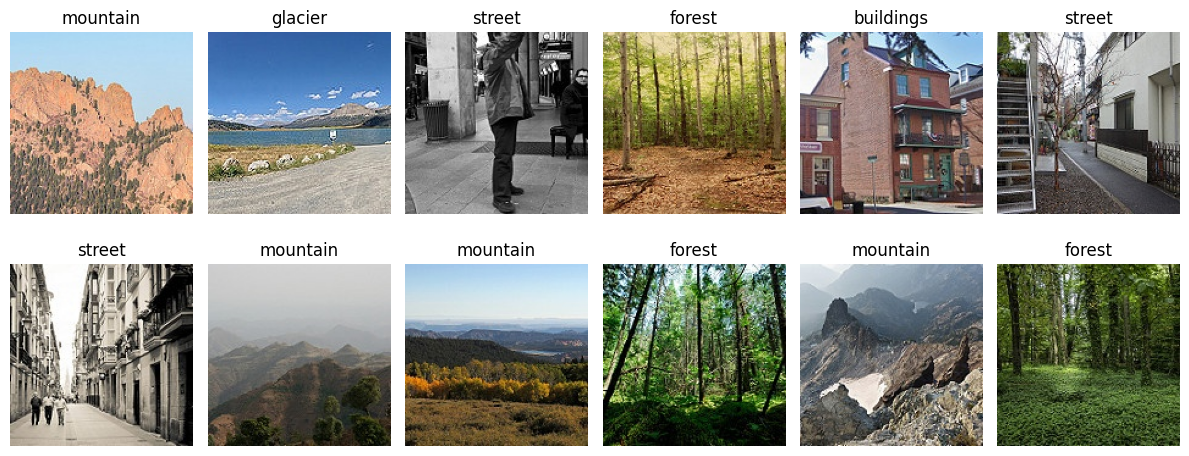

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_batch(generator, n=12):
    x, y = next(generator)
    n = min(n, x.shape[0])
    cols = 6
    rows = math.ceil(n / cols)
    plt.figure(figsize=(12, 2.5*rows))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(x[i])
        plt.title(list(generator.class_indices.keys())[np.argmax(y[i])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_batch(train_gen_v1, n=12)


## 5. Modelo V1 — CNN Base

**Arquitectura:**
- 3 bloques: Conv2D + ReLU + MaxPooling2D
- Flatten → Dense(128, ReLU) → Dropout(0.5)
- Capa de salida: Dense(num_classes, softmax)

**Técnicas:**
- Dropout(0.5) como regularización
- Optimizador: Adam
- Función de pérdida: categorical_crossentropy
- Métrica: accuracy


In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model_v1 = models.Sequential([
    layers.Input(shape=(*IMG_SIZE_V1V2, 3)),
    layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(128,3, activation='relu'), layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
model_v1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_v1.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,126 (18.42 MB)

 Trainable params: 4,829,126 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento del modelo

Se usan **callbacks** para mejorar la eficiencia:
- *EarlyStopping*: detiene el entrenamiento si no mejora.
- *ModelCheckpoint*: guarda el mejor modelo.


In [29]:
callbacks_v1 = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=str(MODELS_DIR / 'best_v1.keras'), monitor='val_accuracy', save_best_only=True)
]

history_v1 = model_v1.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=callbacks_v1
)


Epoch 1/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 65s 92ms/step - accuracy: 0.6076 - loss: 1.0227 - val_accuracy: 0.7015 - val_loss: 0.7934
Epoch 2/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 62s 89ms/step - accuracy: 0.6736 - loss: 0.8703 - val_accuracy: 0.7422 - val_loss: 0.7033
Epoch 3/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 66s 94ms/step - accuracy: 0.7404 - loss: 0.7156 - val_accuracy: 0.7482 - val_loss: 0.6550
Epoch 4/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 58s 83ms/step - accuracy: 0.7869 - loss: 0.5916 - val_accuracy: 0.8124 - val_loss: 0.5372
Epoch 5/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 59s 85ms/step - accuracy: 0.8175 - loss: 0.5093 - val_accuracy: 0.8103 - val_loss: 0.5591
Epoch 6/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - accuracy: 0.8504 - loss: 0.4228 - val_accuracy: 0.8320 - val_loss: 0.5111
Epoch 7/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - accuracy: 0.8752 - loss: 0.3580 - val_accuracy: 0.8103 - val_loss: 0.5657
Epoch 8/20
702/702 ━━━━━━━━━━━━━━━━━━━━ 59s 84ms/step - accuracy: 0.8927 - loss: 0.3000 - 

### Análisis visual del entrenamiento
Las curvas de entrenamiento de *loss* y *accuracy* permiten observar el desempeño. Lo que nos sirve para ver si existe algún sobreajuste. 

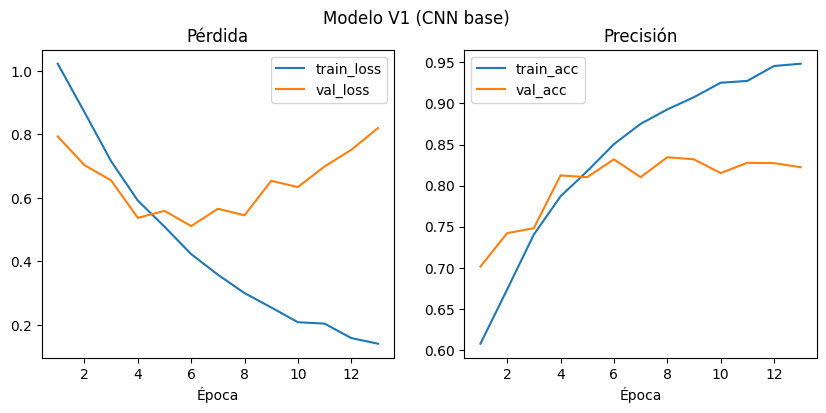

In [30]:
def plot_history(history, title='Histórico de entrenamiento'):
    hist = history.history
    epochs = range(1, len(hist['loss'])+1)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, hist['loss'], label='train_loss')
    plt.plot(epochs, hist['val_loss'], label='val_loss')
    plt.title('Pérdida'); plt.xlabel('Época'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, hist['accuracy'], label='train_acc')
    plt.plot(epochs, hist['val_accuracy'], label='val_acc')
    plt.title('Precisión'); plt.xlabel('Época'); plt.legend()

    plt.suptitle(title)
    plt.show()

plot_history(history_v1, title='Modelo V1 (CNN base)')


In [ ]:
import gc, torch, keras
try:
    del history_v1, model_v1
except NameError:
    pass
gc.collect()
torch.cuda.empty_cache()
keras.backend.clear_session()


## 8. Modelo V2 — CNN con Bloques Squeeze-and-Excitation

- Se añaden **bloques Squeeze-and-Excitation (SE)** para recalibrar canales y mejorar la representación de características.
- Se utiliza **BatchNorm** y **Dropout** como regularización para reducir sobreajuste.

In [19]:

import keras
from keras import layers, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint


# Bloque SE (Squeeze-and-Excitation)
class SEBlock(layers.Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        super().__init__(**kwargs)
        self.reduction_ratio = reduction_ratio
    def build(self, input_shape):
        channels = input_shape[-1]
        reduced = max(channels // self.reduction_ratio, 4)
        self.gap = layers.GlobalAveragePooling2D()
        self.fc1 = layers.Dense(reduced, activation="relu")
        self.fc2 = layers.Dense(channels, activation="sigmoid")
        self.reshape = layers.Reshape((1, 1, channels))
    def call(self, x):
        s = self.gap(x)
        s = self.fc1(s)
        s = self.fc2(s)
        s = self.reshape(s)
        return x * s

def build_model_with_se(input_shape, num_classes, se_ratio=16, drop=0.5):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = SEBlock(se_ratio)(x); x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = SEBlock(se_ratio)(x); x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = SEBlock(se_ratio)(x); x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.Dropout(drop)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

model_v2 = build_model_with_se(input_shape=(*IMG_SIZE_V1V2, 3), num_classes=num_classes)
model_v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_v2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ se_block (SEBlock)              │ (None, 150, 150, 32)   │           292 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ se_block_1 (SEBlock)            │ (None, 75, 75, 64)     │           580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 309,078 (1.18 MB)

 Trainable params: 307,926 (1.17 MB)

 Non-trainable params: 1,152 (4.50 KB)

### Entrenamiento del modelo

Se usan **callbacks** para mejorar la eficiencia:
- *EarlyStopping*: detiene el entrenamiento si no mejora.
- *ModelCheckpoint*: guarda el mejor modelo.

In [20]:
callbacks_v2 = [
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True),
    ModelCheckpoint(filepath=str(MODELS_DIR / 'model_v2_best.keras'), monitor='val_accuracy', save_best_only=True)
]

history_v2 = model_v2.fit(
    train_gen,               
    epochs=15,
    validation_data=val_gen, 
    callbacks=callbacks_v2
)

model_v2.save(MODELS_DIR / "model_v2_final.keras")


Epoch 1/15
702/702 ━━━━━━━━━━━━━━━━━━━━ 86s 122ms/step - accuracy: 0.6006 - loss: 1.0464 - val_accuracy: 0.6024 - val_loss: 0.9681
Epoch 2/15
702/702 ━━━━━━━━━━━━━━━━━━━━ 81s 115ms/step - accuracy: 0.7283 - loss: 0.7386 - val_accuracy: 0.7265 - val_loss: 0.7162
Epoch 3/15
702/702 ━━━━━━━━━━━━━━━━━━━━ 84s 119ms/step - accuracy: 0.7752 - loss: 0.6247 - val_accuracy: 0.7671 - val_loss: 0.5864
Epoch 4/15
702/702 ━━━━━━━━━━━━━━━━━━━━ 82s 116ms/step - accuracy: 0.7969 - loss: 0.5633 - val_accuracy: 0.7557 - val_loss: 0.6572
Epoch 5/15
702/702 ━━━━━━━━━━━━━━━━━━━━ 79s 112ms/step - accuracy: 0.8097 - loss: 0.5196 - val_accuracy: 0.7889 - val_loss: 0.5383
Epoch 6/15
702/702 ━━━━━━━━━━━━━━━━━━━━ 79s 112ms/step - accuracy: 0.8300 - loss: 0.4723 - val_accuracy: 0.7247 - val_loss: 0.7563
Epoch 7/15
702/702 ━━━━━━━━━━━━━━━━━━━━ 81s 115ms/step - accuracy: 0.8319 - loss: 0.4687 - val_accuracy: 0.7956 - val_loss: 0.5735
Epoch 8/15
702/702 ━━━━━━━━━━━━━━━━━━━━ 82s 117ms/step - accuracy: 0.8398 - loss: 0

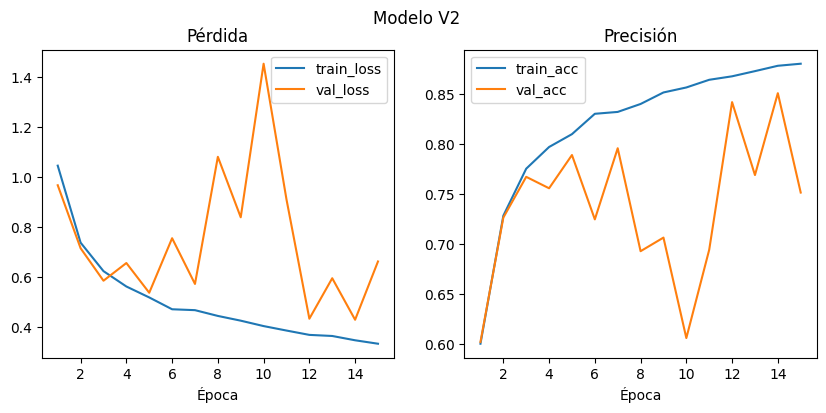

In [21]:
def plot_history(history, title='Histórico de entrenamiento'):
    hist = history.history
    epochs = range(1, len(hist['loss'])+1)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, hist['loss'], label='train_loss')
    plt.plot(epochs, hist['val_loss'], label='val_loss')
    plt.title('Pérdida'); plt.xlabel('Época'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, hist['accuracy'], label='train_acc')
    plt.plot(epochs, hist['val_accuracy'], label='val_acc')
    plt.title('Precisión'); plt.xlabel('Época'); plt.legend()

    plt.suptitle(title)
    plt.show()

plot_history(history_v2, title='Modelo V2')

## 9. Modelo V3 — Transfer Learning con ResNet50

- Red base: **ResNet50** preentrenada en *ImageNet*.
- Cabeza densa con **BatchNorm** y **Dropout** para mejorar generalización.



In [20]:
# MODELO V3: Transfer Learning con ResNet50

import keras
from keras import layers, Model
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Base preentrenada en ImageNet
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(*IMG_SIZE_V3, 3)
)

# Congelamos capas base para entrenar solo el header
base_model.trainable = False

# Header del modelo
inputs = layers.Input(shape=(*IMG_SIZE_V3, 3))
x = preprocess_input(inputs)                
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x) 
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_v3 = Model(inputs, outputs)
model_v3.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_v3.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_3[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_10[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 6)         │      1,542 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,114,822 (91.99 MB)

 Trainable params: 526,598 (2.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

### Entrenamiento del modelo

Se usan **callbacks** para mejorar la eficiencia:
- *EarlyStopping*: detiene el entrenamiento si no mejora.
- *ModelCheckpoint*: guarda el mejor modelo.

In [ ]:
callbacks_v3 = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=str(MODELS_DIR / "model_v3_best.keras"),
                    save_best_only=True, monitor='val_accuracy')
]

history_v3 = model_v3.fit(
    train_gen_v3,
    validation_data=val_gen_v3,
    epochs=12,
    callbacks=callbacks_v3
)

model_v3.save(MODELS_DIR / "model_v3_final.keras")

Epoch 1/12
351/351 ━━━━━━━━━━━━━━━━━━━━ 161s 458ms/step - accuracy: 0.8747 - loss: 0.3523 - val_accuracy: 0.8912 - val_loss: 0.3083
Epoch 2/12
351/351 ━━━━━━━━━━━━━━━━━━━━ 144s 411ms/step - accuracy: 0.8965 - loss: 0.2972 - val_accuracy: 0.8912 - val_loss: 0.3215
Epoch 3/12
351/351 ━━━━━━━━━━━━━━━━━━━━ 173s 495ms/step - accuracy: 0.9015 - loss: 0.2744 - val_accuracy: 0.8969 - val_loss: 0.3007
Epoch 4/12
351/351 ━━━━━━━━━━━━━━━━━━━━ 206s 588ms/step - accuracy: 0.9029 - loss: 0.2663 - val_accuracy: 0.8973 - val_loss: 0.2942
Epoch 5/12
351/351 ━━━━━━━━━━━━━━━━━━━━ 181s 516ms/step - accuracy: 0.9069 - loss: 0.2535 - val_accuracy: 0.9016 - val_loss: 0.2752
Epoch 6/12
351/351 ━━━━━━━━━━━━━━━━━━━━ 175s 499ms/step - accuracy: 0.9123 - loss: 0.2386 - val_accuracy: 0.9091 - val_loss: 0.2687
Epoch 7/12
351/351 ━━━━━━━━━━━━━━━━━━━━ 178s 508ms/step - accuracy: 0.9163 - loss: 0.2331 - val_accuracy: 0.8998 - val_loss: 0.2856
Epoch 8/12
351/351 ━━━━━━━━━━━━━━━━━━━━ 177s 506ms/step - accuracy: 0.9167 -

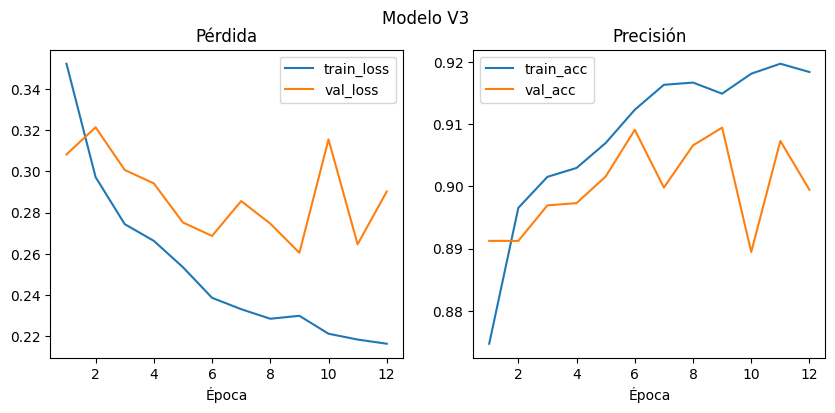

In [31]:
def plot_history(history, title='Histórico de entrenamiento'):
    hist = history.history
    epochs = range(1, len(hist['loss'])+1)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, hist['loss'], label='train_loss')
    plt.plot(epochs, hist['val_loss'], label='val_loss')
    plt.title('Pérdida'); plt.xlabel('Época'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, hist['accuracy'], label='train_acc')
    plt.plot(epochs, hist['val_accuracy'], label='val_acc')
    plt.title('Precisión'); plt.xlabel('Época'); plt.legend()

    plt.suptitle(title)
    plt.show()

plot_history(history_v3, title='Modelo V3')

## 10. Evaluación Final

Los tres modelos desarrollados (V1, V2 y V3) son evaluados mediante un reporte de clasificación, matrices de confusión y el accuracy obtenido sobre los conjuntos de validación y prueba. Estas métricas permiten analizar el desempeño por clase, identificar errores frecuentes y verificar la capacidad de generalización del modelo. Además se guarda el SEBlock para poder evaluar el modelo ya entrenado. Se toman en cuenta los modelos ya que en la primera entrega no fueron contemplados. En esta carga ya se encuentran definidos y evaluados correspondientemente.


In [37]:
# Class order para evaluación de los modelos
gen_tmp = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE_V1V2,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

class_order = list(gen_tmp.class_indices.keys())
print("Orden de clases encontrado en disco:", class_order)

# Se guarda en models/class_order.json
class_order_path = MODELS_DIR / "class_order.json"

with open(class_order_path, "w", encoding="utf-8") as f:
    json.dump(class_order, f, indent=2)

print("class_order.json guardado en:", class_order_path)


Found 14034 images belonging to 6 classes.
Orden de clases encontrado en disco: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_order.json guardado en: models\class_order.json


Cargando BEST: models\best_v1.keras
Cargando BEST: models\model_v2_best.keras
Cargando BEST: models\model_v3_best.keras
Orden de clases cargado: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.

V1 (Validación - BEST)
              precision    recall  f1-score   support

   buildings     0.8341    0.7922    0.8126       438
      forest     0.9770    0.9361    0.9561       454
     glacier     0.7702    0.7958    0.7828       480
    mountain     0.7617    0.8088    0.7845       502
         sea     0.8778    0.7907    0.8320       454
      street     0.8175    0.8845    0.8496       476

    accuracy                         0.8345      2804
   macro avg     0.8397    0.8347    0.8363      2804
weighted avg     0.8376    0.8345    0.8351      2804



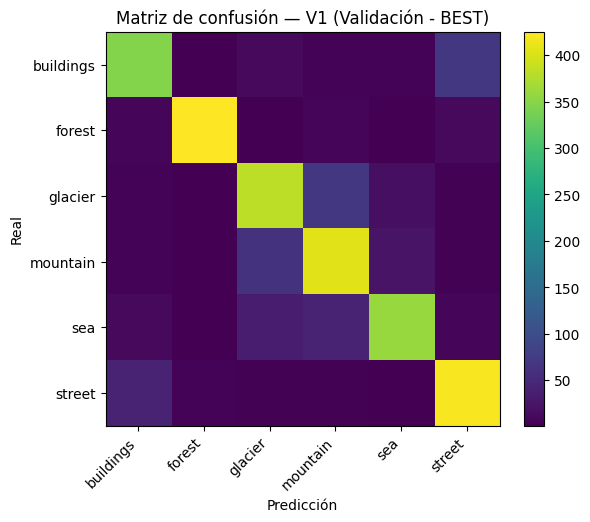


V2 (Validación - BEST)
              precision    recall  f1-score   support

   buildings     0.8549    0.8744    0.8646       438
      forest     0.9709    0.9559    0.9634       454
     glacier     0.8205    0.7521    0.7848       480
    mountain     0.7127    0.8845    0.7893       502
         sea     0.9068    0.7930    0.8461       454
      street     0.8976    0.8466    0.8714       476

    accuracy                         0.8506      2804
   macro avg     0.8606    0.8511    0.8532      2804
weighted avg     0.8580    0.8506    0.8516      2804



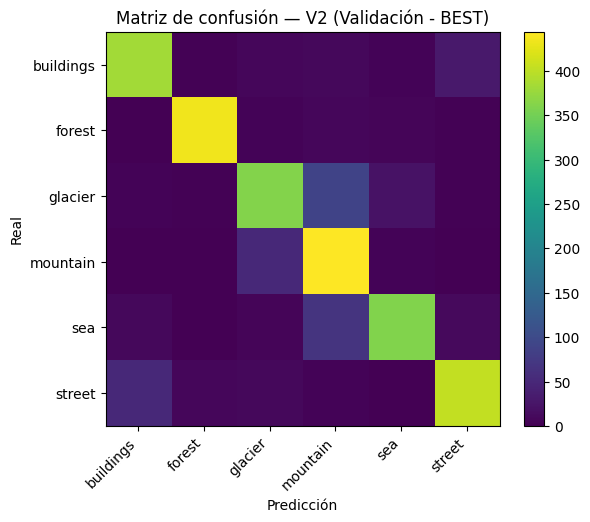


V3 (Validación - BEST)
              precision    recall  f1-score   support

   buildings     0.9435    0.9155    0.9293       438
      forest     0.9738    0.9824    0.9781       454
     glacier     0.8178    0.8604    0.8386       480
    mountain     0.8668    0.8426    0.8545       502
         sea     0.9523    0.9229    0.9374       454
      street     0.9180    0.9412    0.9295       476

    accuracy                         0.9094      2804
   macro avg     0.9120    0.9108    0.9112      2804
weighted avg     0.9103    0.9094    0.9096      2804



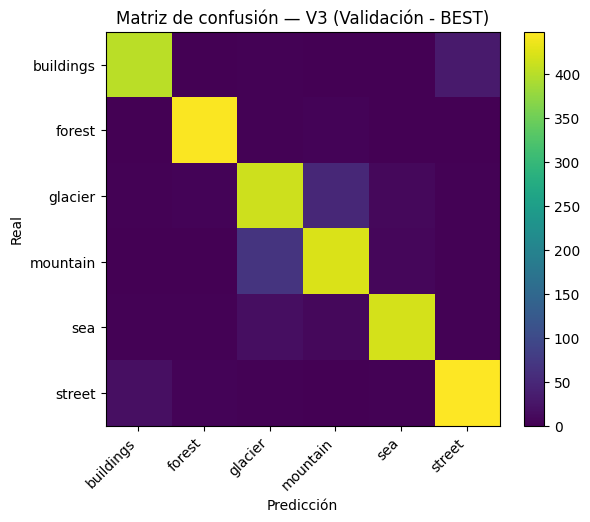


=== Comparativa VALIDACIÓN (BEST) ===


,model,accuracy,samples
2,V3 (Validación - BEST),0.909415,2804
1,V2 (Validación - BEST),0.850571,2804
0,V1 (Validación - BEST),0.834522,2804



=== Comparativa TEST (BEST) ===


,model,loss,accuracy,samples
2,V3 (Test - BEST),0.236651,0.913333,3000
1,V2 (Test - BEST),0.434214,0.839333,3000
0,V1 (Test - BEST),0.562756,0.827667,3000


In [39]:
# Evaluación unificada usando SOLO los modelos BEST guardados
import os, json, math
from pathlib import Path
import numpy as np, matplotlib.pyplot as plt, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input
import keras

from keras import layers
class SEBlock(layers.Layer):
    def __init__(self, reduction_ratio=16, **kwargs):
        super().__init__(**kwargs)
        self.reduction_ratio = reduction_ratio
    def build(self, input_shape):
        channels = input_shape[-1]
        reduced = max(int(channels) // int(self.reduction_ratio), 4)
        self.gap = layers.GlobalAveragePooling2D()
        self.fc1 = layers.Dense(reduced, activation="relu")
        self.fc2 = layers.Dense(channels, activation="sigmoid")
        self.reshape = layers.Reshape((1, 1, channels))
    def call(self, x):
        s = self.gap(x); s = self.fc1(s); s = self.fc2(s); s = self.reshape(s)
        return x * s
    def get_config(self):
        cfg = super().get_config(); cfg.update({"reduction_ratio": self.reduction_ratio}); return cfg

# Utilidades
def steps_for(gen):
    return int(math.ceil(gen.n / gen.batch_size))

def evaluate_and_report(model, generator, title='Evaluación'):
    """Imprime classification_report + matriz de confusión y devuelve dict con métricas."""
    class_names = list(generator.class_indices.keys())
    y_true = generator.classes

    y_prob = model.predict(generator, steps=steps_for(generator), verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    print(f"\n{title}")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Matriz de confusión — {title}')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.xlabel('Predicción'); plt.ylabel('Real')
    plt.show()

    acc = (y_true == y_pred).mean()
    return {"model": title, "accuracy": float(acc), "samples": int(len(y_true))}

def eval_on_test(model, test_gen, title='(Test)'):
    loss, acc = model.evaluate(test_gen, steps=steps_for(test_gen), verbose=0)
    return {"model": title, "loss": float(loss), "accuracy": float(acc), "samples": int(test_gen.n)}

# Carga EXCLUSIVA de modelos BEST
MODELS_DIR = MODELS_DIR if 'MODELS_DIR' in locals() else Path("models")
MODELS_DIR = Path(MODELS_DIR)

def load_best(fname):
    fpath = MODELS_DIR / fname
    if os.path.exists(fpath):
        print(f"Cargando BEST: {fpath}")
        m = keras.models.load_model(
            fpath,
            custom_objects={"SEBlock": SEBlock},
            compile=False,
            safe_mode=False
        )
        m.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
        return m
    print(f"BEST no encontrado: {fpath}  (se omite)")
    return None

# Mejores modelos
model_v1 = load_best("best_v1.keras")
model_v2 = load_best("model_v2_best.keras")
model_v3 = load_best("model_v3_best.keras")
has_v3   = model_v3 is not None

# Orden de clases
class_order_path = MODELS_DIR / "class_order.json"
if not class_order_path.exists():
    raise RuntimeError(
        f"No encontró {class_order_path}. "
        "Guarda 'class_order.json' al entrenar con list(train_gen.class_indices.keys())."
    )
with open(class_order_path, "r", encoding="utf-8") as f:
    class_order = json.load(f)
print(f"Orden de clases cargado: {class_order}")

# V1/V2 (150x150, rescale)
val_eval_gen_150 = ImageDataGenerator(rescale=1./255, validation_split=VAL_SPLIT).flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE_V1V2,
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
    shuffle=False,
    classes=class_order,
    seed=SEED
)

test_gen_150 = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE_V1V2,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    classes=class_order
)

# V3 (224x224, preprocess_input)
if has_v3:
    val_gen_v3_eval = ImageDataGenerator(
        preprocessing_function=preprocess_input, validation_split=VAL_SPLIT
    ).flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE_V3,
        batch_size=BATCH_SIZE,
        subset='validation',
        class_mode='categorical',
        shuffle=False,
        classes=class_order,
        seed=SEED
    )
    test_gen_224 = ImageDataGenerator(
        preprocessing_function=preprocess_input
    ).flow_from_directory(
        TEST_DIR,
        target_size=IMG_SIZE_V3,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        classes=class_order
    )

# ---------- Evaluación (Validación) ----------
results = []
if model_v1 is not None:
    results.append(evaluate_and_report(model_v1, val_eval_gen_150, title='V1 (Validación - BEST)'))
if model_v2 is not None:
    results.append(evaluate_and_report(model_v2, val_eval_gen_150, title='V2 (Validación - BEST)'))
if has_v3:
    try:
        results.append(evaluate_and_report(model_v3, val_gen_v3_eval, title='V3 (Validación - BEST)'))
    except Exception as e:
        print("Aviso: no se pudo evaluar V3 en validación:", e)

# ---------- Evaluación (Test) ----------
test_rows = []
if model_v1 is not None:
    test_rows.append(eval_on_test(model_v1, test_gen_150,  title='V1 (Test - BEST)'))
if model_v2 is not None:
    test_rows.append(eval_on_test(model_v2, test_gen_150,  title='V2 (Test - BEST)'))
if has_v3:
    test_rows.append(eval_on_test(model_v3, test_gen_224, title='V3 (Test - BEST)'))

# ---------- Tablas resumen ----------
df_val  = pd.DataFrame(results)
df_test = pd.DataFrame(test_rows) if len(test_rows) else pd.DataFrame()

print("\n=== Comparativa VALIDACIÓN (BEST) ===")
display(df_val.sort_values("accuracy", ascending=False))

if len(df_test):
    print("\n=== Comparativa TEST (BEST) ===")
    display(df_test.sort_values("accuracy", ascending=False))



Después de la modificación realizada para poder obtener los valores correctos durante el test, podemos observar que el que tiene mejor rendimiento sigue siendo el modelo 3. Sin duda el utilizar ResNet ayuda a que el entrenamiento sea más rápido y se obtengan mejores resultados a comparación de entrenar un modelo desde cero. 

## 11. Aplicación — Predicción de imagen nueva

Función para probar el modelo con una imagen individual.


Se mostrarán las predicciones de los modelos V3 y V2 comenzando por el que tuvo mejor desempeño. Considerando claro las imágenes en un tamaño de 244x244.

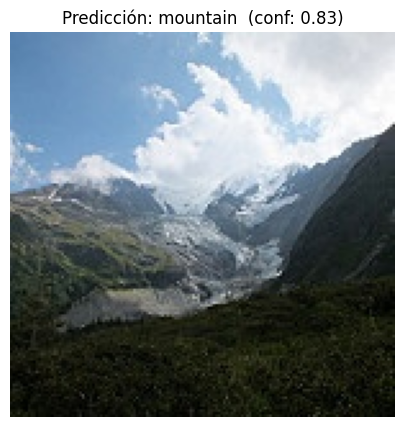

Top-3 probabilidades:
  mountain    0.830
  glacier     0.170
  sea         0.000

Imagen usada: data\seg_test\glacier\21102.jpg


In [ ]:
# Predicción de imagen nueva (Modelo V3 - ResNet50)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import json, random, os

# Rutas
SEG_PRED_DIR = DATASET_BASE / "seg_pred"
MODEL_V3_PATH = MODELS_DIR / "model_v3_best.keras"  

try:
    model_v3
except NameError:
    from keras.models import load_model
    model_v3 = load_model(MODEL_V3_PATH)

# Mapeo de clases
try:
    class_indices = train_gen_v3.class_indices
except NameError:
    # Carga desde labels.json
    labels_path = Path("labels.json")
    if labels_path.exists():
        with open(labels_path, "r", encoding="utf-8") as f:
            idx_to_class = json.load(f)       
            idx_to_class = {int(k): v for k, v in idx_to_class.items()}
    else:
        classes = sorted([d for d in os.listdir(TRAIN_DIR) if (TRAIN_DIR/d).is_dir()])
        idx_to_class = {i: c for i, c in enumerate(classes)}
else:
    idx_to_class = {v: k for k, v in class_indices.items()}  # {idx: class}

# Función de predicción para V3
def predict_image_v3(img_path, model, target_size=(224, 224), top_k=3):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)  
    prob = model.predict(x, verbose=0)[0]  # vector de probabilidades
    pred_idx = int(np.argmax(prob))
    # Top-k
    top_indices = np.argsort(prob)[::-1][:top_k]
    top = [(idx_to_class[i], float(prob[i])) for i in top_indices]
    return idx_to_class[pred_idx], float(prob[pred_idx]), top

# Tomar una imagen de seg_pred 
candidates = []
if SEG_PRED_DIR.exists():
    candidates = [p for p in SEG_PRED_DIR.glob("*") if p.is_file() and p.suffix.lower() in {".jpg",".jpeg",".png"}]
if not candidates:
    candidates = [p for p in (TEST_DIR).rglob("*") if p.is_file() and p.suffix.lower() in {".jpg",".jpeg",".png"}]

assert len(candidates) > 0, "No se encontraron imágenes en seg_pred/ ni en seg_test/"

img_path = random.choice(candidates)
pred_label, pred_conf, top3 = predict_image_v3(img_path, model_v3, target_size=(224,224))

# Mostrar imagen + predicción
plt.figure(figsize=(5,5))
plt.imshow(Image.open(img_path).convert("RGB"))
plt.axis("off")
plt.title(f"Predicción: {pred_label}  (conf: {pred_conf:.2f})")
plt.show()

print("Top-3 probabilidades:")
for cls, p in top3:
    print(f"  {cls:10s}  {p:.3f}")
print("\nImagen usada:", img_path)


En este segundo modelo se realiza el mismo procedimiento pero con el tamaño de imagen de 150x150

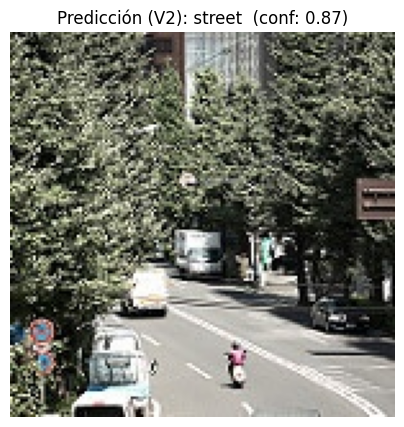

Top-3 probabilidades (V2):
  street      0.870
  forest      0.066
  buildings   0.055

Imagen usada: data\seg_test\street\23471.jpg


In [68]:
# Predicción con MODELO V2 (CNN personalizada)

# Carpeta de predicción
SEG_PRED_DIR = DATASET_BASE / "seg_pred"

# Cargar modelo V2 si no está en memoria
MODEL_V2_PATH = MODELS_DIR / "model_v2_final.keras"
try:
    model_v2
except NameError:
    from tensorflow.keras.models import load_model
    model_v2 = load_model(MODEL_V2_PATH)

# Cargar labels
labels_path = Path("labels.json")
if labels_path.exists():
    with open(labels_path, "r", encoding="utf-8") as f:
        idx_to_class = json.load(f)
        idx_to_class = {int(k): v for k, v in idx_to_class.items()}
else:
    classes = sorted([d for d in os.listdir(TRAIN_DIR) if (TRAIN_DIR/d).is_dir()])
    idx_to_class = {i: c for i, c in enumerate(classes)}

# Función para predecir con V2
def predict_image_v2(img_path, model, target_size=(150,150), top_k=3):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)/255.0
    x = np.expand_dims(x, axis=0)
    prob = model.predict(x, verbose=0)[0]
    
    pred_idx = int(np.argmax(prob))
    top_indices = np.argsort(prob)[::-1][:top_k]
    top = [(idx_to_class[i], float(prob[i])) for i in top_indices]
    return idx_to_class[pred_idx], float(prob[pred_idx]), top

# Buscar imagen en seg_pred
candidates = []
if SEG_PRED_DIR.exists():
    candidates = [p for p in SEG_PRED_DIR.glob("*") if p.is_file() and p.suffix.lower() in {".jpg",".jpeg",".png"}]

if not candidates:
    candidates = [p for p in TEST_DIR.rglob("*") if p.is_file() and p.suffix.lower() in {".jpg",".jpeg",".png"}]

assert len(candidates) > 0, "No se encontraron imágenes en seg_pred ni en seg_test"

img_path = random.choice(candidates)
pred_label, pred_conf, top3 = predict_image_v2(img_path, model_v2)

# Mostrar resultado
plt.figure(figsize=(5,5))
plt.imshow(Image.open(img_path).convert("RGB"))
plt.axis("off")
plt.title(f"Predicción (V2): {pred_label}  (conf: {pred_conf:.2f})")
plt.show()

print("Top-3 probabilidades (V2):")
for cls, p in top3:
    print(f"  {cls:10s}  {p:.3f}")

print("\nImagen usada:", img_path)


## Conclusiones

Se evaluaron tres modelos para la clasificación de escenas: una CNN base (V1), una CNN mejorada con squeze and excitation (V2) y un modelo con Transfer Learning usando ResNet50 (V3). Los resultados muestran diferencias claras en capacidad de aprendizaje y generalización.

**V1 – Modelo Base (CNN desde cero):**
Actuó solo como referencia, ya que obtuvo una precisión de validación cercana a 0.17. Es prácticamente una selección aleatoria entre las 3 clases. La pérdida de validación no mejoró y la matriz de confusión muestra clasificaciones prácticamente uniformes. Lo que podemos decir es que el modelo no logró aprender patrones visuales relevantes.

**V2 – CNN con bloques Squeeze-and-Excitation, Batch Normalization, Dropout:**
Aunque mejoró la estabilidad respecto a V1, su precisión también quedó en 0.17 en validación y las predicciones siguieron siendo casi aleatorias. Sin embargo, en test alcanzó 0.85, pero con variaciones fuertes entre clases. Lo que se logró fue tener una mejor regularización, pero insuficiente para la complejidad del dataset. Lo que nos lleva a la última implementación.

**V3 – Transfer Learning con ResNet50 (Mejor Modelo):**
Fue el único modelo que realmente aprendió las diferencias entre clases. Alcanzó 0.91 de accuracy en validación y 0.91 en test, con F1-scores superiores al 80% en todas las categorías. La matriz de confusión muestra una diagonal clara, indicando una clasificación consistente. Además, las curvas de pérdida y accuracy se mantuvieron estables sin sobreajuste.

Con ello podemos decir que los modelos pequeños (V1 y V2) no lograron capturar patrones visuales complejos. En cambio, ResNet50 aprovechó el conocimiento preentrenado en ImageNet y permitió una clasificación precisa y generalizable. Por su estabilidad y más de 90% de exactitud, el modelo V3 es el más adecuado para aplicación real y despliegue. Esto queda más que comprobado en la implementación de predicción con las diferentes imágenes.